In [1]:
import numpy as np
import random
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

## kd树及最近邻算法

In [2]:
# kd树
class kdtree:
    def __init__(self, X : np.ndarray) -> None:
        if type(X) == str:
            self.tree_size = None
            self.node = None
            self.k = None
            self.node_to_index = None
            self.area = None
        if type(X) == np.ndarray:
            self.tree_size = X.shape[0]
            self.node = {}
            self.area = {}
            self.node_to_index = {}
            self.k = X.shape[1]
            self.create_tree(X)
            self.__area()
    
    # 创建tree
    def create_tree(self, X : np.ndarray, d=0, node=1, add_index=True) -> None:
        dim = d%self.k
        X_copy = X.copy()
        N = X_copy.shape[0]
        if add_index:
            X_copy = np.hstack((X_copy,(np.arange(N)).reshape(-1,1)))
        if N > 0:
            [median_index, median] = RANDOMIZED_SELECT(list(X_copy[:,dim]),[i for i in range(N)],0,N-1,int(N/2)+1)
            self.node[node] = X_copy[median_index,0:-1]
            self.node_to_index[node] = int(X_copy[median_index,-1])
            X_copy = np.delete(X_copy,median_index,0)
            left_part = X_copy[X_copy[:,dim] <= median]
            right_part = X_copy[X_copy[:,dim] > median]
            self.create_tree(left_part,d+1,self.__LEFT(node),False)
            self.create_tree(right_part,d+1,self.__RIGHT(node),False) 
    
    # 找到包含目标点的叶节点
    def find_node(self, x : np.ndarray, start_node = 1) -> list:
        """
        Return
        ----------
        (node_index, node) : tuple
        返回包含目标点x的叶节点索引node_index和对应的叶节点node
        """
        d = (int(np.log2(start_node)))%self.k
        if x[d] <= self.node[start_node][d]:
            if self.__LEFT(start_node) not in self.node:
                return start_node, self.node[start_node]
            else:
                return self.find_node(x,self.__LEFT(start_node))
        else:
            if self.__RIGHT(start_node) not in self.node:
                return start_node, self.node[start_node]
            else:
                return self.find_node(x,self.__RIGHT(start_node))
    
    # kd最近邻搜索
    def nearest_search(self, x : np.ndarray, start_node=1) -> np.ndarray:
        # 向父节点递归的函数
        def recursive_parent(x : np.ndarray, node : int, nearest_distance : float, nearest_index : int, header : int):
            parent = self.__PARENT(node)
            if parent >= header:
                if np.linalg.norm(x-self.node[parent]) < nearest_distance:
                    nearest_index = parent
                    nearest_distance = np.linalg.norm(x-self.node[parent])
                another_child = self.__LEFT(parent) if self.__LEFT(parent) != node else self.__RIGHT(parent)
                # 判断区域是否相交
                if another_child in self.node:
                    if self.__INTERSECT(another_child,x,nearest_distance):
                        another_nearest = self.nearest_search(x,another_child)
                        if another_nearest[1] < nearest_distance:
                            nearest_index = another_nearest[0]
                            nearest_distance = another_nearest[1]
                return recursive_parent(x, parent, nearest_distance, nearest_index, header)
            else:
                return [nearest_index, nearest_distance]
        
        nearest_index, nearest_node = self.find_node(x,start_node)
        nearest_distance = np.linalg.norm(x-nearest_node)
        left_child = self.__LEFT(nearest_index)
        right_child = self.__RIGHT(nearest_index)
        if left_child in self.node:
            left_distance = np.linalg.norm(x-self.node[left_child])
            if left_distance < nearest_distance:
                nearest_index = left_child
                nearest_distance = left_distance
        if right_child in self.node:
            right_distance = np.linalg.norm(x-self.node[right_child])
            if right_distance < nearest_distance:
                nearest_index = right_child
                nearest_distance = right_distance
        return recursive_parent(x, nearest_index, nearest_distance, nearest_index, start_node)
    
    def copy(self):
        tree_copy = kdtree('copy')
        tree_copy.k = self.k
        tree_copy.tree_size = self.tree_size
        tree_copy.node = self.node.copy()
        tree_copy.node_to_index = self.node_to_index.copy()
        tree_copy.area = self.area.copy()
        return tree_copy

    # 返回节点所占有的范围
    def __area(self) -> None:
        for node in self.node:
            _node = node
            area = [[-np.inf,np.inf] for i in range(self.k)]
            while self.__PARENT(node) != 0:
                parent = self.__PARENT(node)
                d = (int(np.log2(parent)))%self.k 
                if self.__LEFT(parent) == node:
                    area[d][1] = self.node[parent][d]
                else:
                    area[d][0] = self.node[parent][d]
                node = parent
            self.area[_node] = np.array(area)

    def __LEFT(self, i : int) -> int:
        return i << 1
    
    def __RIGHT(self, i : int) -> int:
        return (i << 1) + 1
    
    def __PARENT(self, i : int) -> int:
        return i >> 1
    
    def __INTERSECT(self, node : int, center : np.ndarray, radius : float) -> bool:
        area = self.area[node]
        area[:,0] -= radius
        area[:,1] += radius
        check = center.reshape(-1,1) - area
        check[:,-1] *= -1
        return (check<=0).any()

## k分位数算法

In [3]:
def RANDOMIZED_SELECT(A : list, index : list, p : int, r : int, i : int) -> list:
    """
    Return
    ----------
    [index,A[index]] : list
    返回序列A中第i小的数的下标及对应的值
    """
    def PARTITION(A,index,p,r):
        x = A[r]
        i = p - 1
        for j in range(p,r):
            if A[j] <= x:
                i = i + 1
                A[i], A[j] = A[j], A[i]
                index[i], index[j] = index[j], index[i]
        A[i+1], A[r] = A[r], A[i+1]
        index[i+1], index[r] = index[r], index[i+1]
        return i + 1

    def RANDOMIZED_PARTITION(A,index,p,r):
        q = random.randint(p,r)
        A[r],A[q] = A[q],A[r]
        index[r],index[q] = index[q],index[r]
        return PARTITION(A,index,p,r)
    
    if p == r:
        return [index[p], A[p]]
    else:
        q = RANDOMIZED_PARTITION(A,index,p,r)
        k = q - p + 1
        if i == k:
            return [index[q], A[q]]
        if i < k:
            return RANDOMIZED_SELECT(A,index,p,q-1,i)
        if i > k:
            return RANDOMIZED_SELECT(A,index,q+1,r,i-k)

## k近邻算法

In [4]:
class KNN:
    def __init__(self, k : int) -> None:
        self.k = k
        self.dim = None
        self.n_class = None
        self.tree = None
        self.label = None
    
    def fit(self, X : np.ndarray, y : np.ndarray) -> None:
        self.tree = kdtree(X)
        self.dim = X.shape[1]
        self.n_class = np.unique(y)
        self.label = y.flatten().tolist()

    def predict(self, X : np.ndarray) -> np.ndarray:
        kill_node = np.array([np.inf for i in range(self.dim)])
        N = X.shape[0]
        y_pred = np.zeros((N,1))
        for i in range(N):
            tree = self.tree.copy()
            vote_dict = {}
            for c in self.n_class:
                vote_dict[c] = 0
            for j in range(self.k):
                nearest_node,_ = tree.nearest_search(X[i])
                vote_dict[self.label[tree.node_to_index[nearest_node]]] += 1
                tree.node[nearest_node] = kill_node
            y_pred[i] = sorted(vote_dict.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)[0][0]
        return y_pred
    
    def accuracy(self, X : np.ndarray, y_true : np.ndarray) -> float:
        y_pred = self.predict(X)
        return (y_pred == y_true).sum() / len(y_true)

## 训练和预测

### 两类别线性可分问题

In [5]:
x_1 = np.concatenate((0.15*np.random.randn(100,1)+0.25,
                      0.15*np.random.randn(100,1)+0.75),axis=1)
x_2 = np.concatenate((0.15*np.random.randn(100,1)+0.75,
                      0.15*np.random.randn(100,1)+0.25),axis=1)
y_1 = np.ones((100,1))
y_2 = -np.ones((100,1))
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1,y_1,test_size=0.3)
x_2_train, x_2_test, y_2_train, y_2_test = train_test_split(x_2,y_2,test_size=0.3)
X_train = np.concatenate((x_1_train,x_2_train))
X_test = np.concatenate((x_1_test,x_2_test))
y_train = np.concatenate((y_1_train,y_2_train))
y_test = np.concatenate((y_1_test,y_2_test))

In [6]:
model = KNN(5)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
false_index,_ = np.where(y_pred != y_test)
acc = model.accuracy(X_test,y_test)
print("测试集上准确率为：",acc)

测试集上准确率为： 0.9833333333333333


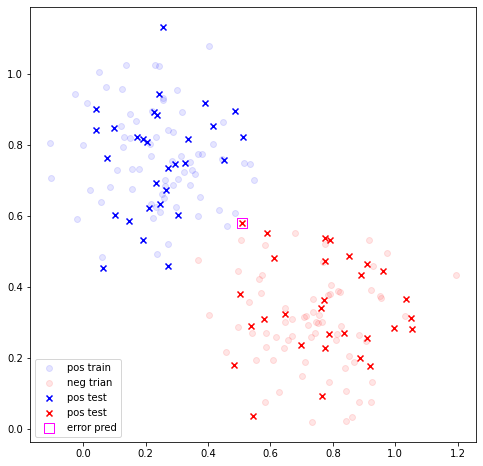

In [7]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x_1_train[:,0],x_1_train[:,1],c='b',label='pos train',alpha=0.1)
plt.scatter(x_2_train[:,0],x_2_train[:,1],c='r',label='neg trian',alpha=0.1)
plt.scatter(x_1_test[:,0],x_1_test[:,1],c='b',marker='x',label='pos test')
plt.scatter(x_2_test[:,0],x_2_test[:,1],c='r',marker='x',label='pos test')
plt.scatter(X_test[false_index,0],X_test[false_index,1],
            color='none',edgecolor='magenta',marker='s',s=100,label='error pred')
plt.legend(loc='lower left')

### 三类别分类

In [8]:
x_1 = np.concatenate((0.15*np.random.randn(100,1)+0.25,
                      0.15*np.random.randn(100,1)+0.75),axis=1)
x_2 = np.concatenate((0.15*np.random.randn(100,1)+0.75,
                      0.15*np.random.randn(100,1)+0.25),axis=1)
x_3 = np.concatenate((0.15*np.random.randn(100,1)+0.95,
                      0.15*np.random.randn(100,1)+0.75),axis=1)
y_1 = np.ones((100,1))
y_2 = 2*np.ones((100,1))
y_3 = 3*np.ones((100,1))
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1,y_1,test_size=0.3)
x_2_train, x_2_test, y_2_train, y_2_test = train_test_split(x_2,y_2,test_size=0.3)
x_3_train, x_3_test, y_3_train, y_3_test = train_test_split(x_3,y_3,test_size=0.3)
X_train = np.concatenate((x_1_train,x_2_train,x_3_train))
X_test = np.concatenate((x_1_test,x_2_test,x_3_test))
y_train = np.concatenate((y_1_train,y_2_train,y_3_train))
y_test = np.concatenate((y_1_test,y_2_test,y_3_test))

In [9]:
model = KNN(5)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
false_index,_ = np.where(y_pred != y_test)
# acc = model.accuracy(X_test,y_test)
print("测试集上准确率为：",acc)

测试集上准确率为： 0.9833333333333333


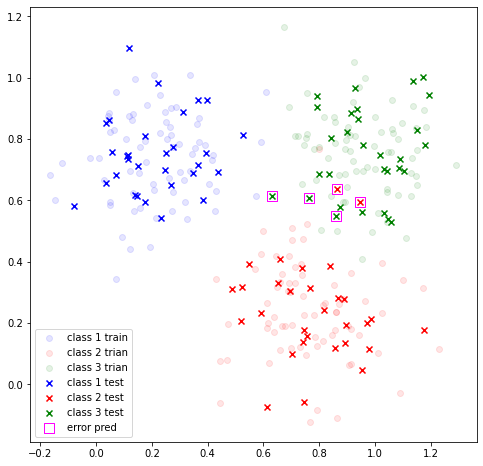

In [10]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x_1_train[:,0],x_1_train[:,1],c='b',label='class 1 train',alpha=0.1)
plt.scatter(x_2_train[:,0],x_2_train[:,1],c='r',label='class 2 trian',alpha=0.1)
plt.scatter(x_3_train[:,0],x_3_train[:,1],c='g',label='class 3 trian',alpha=0.1)
plt.scatter(x_1_test[:,0],x_1_test[:,1],c='b',marker='x',label='class 1 test')
plt.scatter(x_2_test[:,0],x_2_test[:,1],c='r',marker='x',label='class 2 test')
plt.scatter(x_3_test[:,0],x_3_test[:,1],c='g',marker='x',label='class 3 test')
plt.scatter(X_test[false_index,0],X_test[false_index,1],
            color='none',edgecolor='magenta',marker='s',s=100,label='error pred')
plt.legend(loc='lower left')

### 线性不可分问题

In [11]:
x_1 = np.concatenate((0.15*np.random.randn(100,1),
                      0.15*np.random.randn(100,1)),axis=1)
radius = 0.5
x = np.linspace(-radius,radius,100).reshape(-1,1)
x_2 = np.concatenate((x,-np.sqrt(radius**2 - x**2) + 0.15*np.random.randn(100,1)),axis=1)
x_3 = np.concatenate((x,np.sqrt(radius**2 - x**2) + 0.15*np.random.randn(100,1)),axis=1)
y_1 = np.ones((100,1))
y_2 = 2*np.ones((100,1))
y_3 = 3*np.ones((100,1))
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1,y_1,test_size=0.3)
x_2_train, x_2_test, y_2_train, y_2_test = train_test_split(x_2,y_2,test_size=0.3)
x_3_train, x_3_test, y_3_train, y_3_test = train_test_split(x_3,y_3,test_size=0.3)
X_train = np.concatenate((x_1_train,x_2_train,x_3_train))
X_test = np.concatenate((x_1_test,x_2_test,x_3_test))
y_train = np.concatenate((y_1_train,y_2_train,y_3_train))
y_test = np.concatenate((y_1_test,y_2_test,y_3_test))

In [12]:
model = KNN(5)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
false_index,_ = np.where(y_pred != y_test)
acc = model.accuracy(X_test,y_test)
print("测试集上准确率为：",acc)

测试集上准确率为： 0.9111111111111111


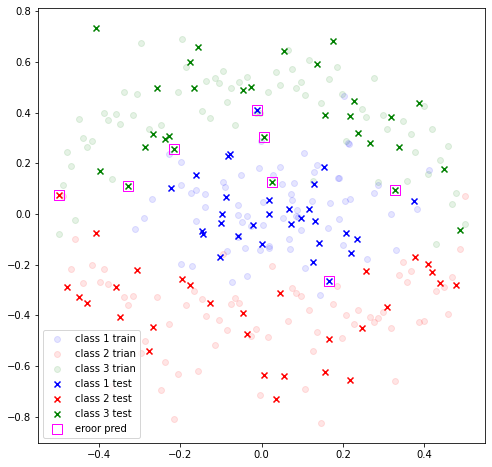

In [13]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x_1_train[:,0],x_1_train[:,1],c='b',label='class 1 train',alpha=0.1)
plt.scatter(x_2_train[:,0],x_2_train[:,1],c='r',label='class 2 trian',alpha=0.1)
plt.scatter(x_3_train[:,0],x_3_train[:,1],c='g',label='class 3 trian',alpha=0.1)
plt.scatter(x_1_test[:,0],x_1_test[:,1],c='b',marker='x',label='class 1 test')
plt.scatter(x_2_test[:,0],x_2_test[:,1],c='r',marker='x',label='class 2 test')
plt.scatter(x_3_test[:,0],x_3_test[:,1],c='g',marker='x',label='class 3 test')
plt.scatter(X_test[false_index,0],X_test[false_index,1],
            color='none',edgecolor='magenta',marker='s',s=100,label='eroor pred')
plt.legend(loc='lower left')

## 计算复杂度测试

In [14]:
time_list = []
time_list_base = []
for N in range(10,10000,100):
    test_data = np.random.randn(N,2)
    tree = kdtree(test_data)
    start = time.time()
    for i in range(300):
        x0 = np.random.randn(2)
        tree.nearest_search(x0)
    end = time.time()
    time_list.append((end-start)/300)
    start = time.time()
    for i in range(300):
        x0 = np.random.randn(2)
        (np.linalg.norm(x0.reshape(1,-1)-test_data,axis=1)).min()
    end = time.time()
    time_list_base.append((end-start)/300)

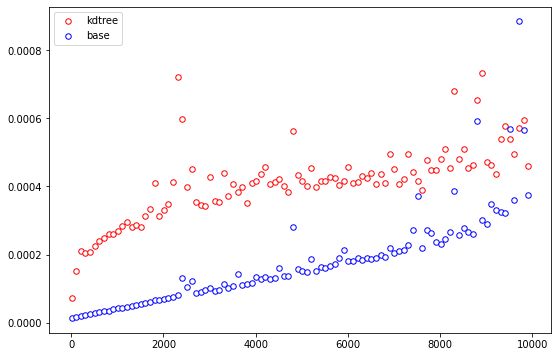

In [15]:
fig = plt.figure(figsize=(9,6))
plt.scatter([i for i in range(10,10000,100)],time_list,
                marker='o',edgecolor='r',c='w',s=30,label='kdtree')
plt.scatter([i for i in range(10,10000,100)],time_list_base,
                marker='o',edgecolor='b',c='w',s=30,label='base')
plt.legend()